In [50]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
from typing import Any, Tuple

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

net = nn.Sequential(
    nn.Conv2d(5, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2 ),
    nn.Conv2d(10, 30, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2 ),
    nn.Flatten(),
    nn.Linear(30,10), nn.ReLU(),
  #  nn.Dropout(p=0.5),
    nn.Linear(10, 2)
)

In [51]:
X = torch.randn(1, 5, 17, 16)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 10, 9, 8])
ReLU output shape:	 torch.Size([1, 10, 9, 8])
MaxPool2d output shape:	 torch.Size([1, 10, 4, 4])
Conv2d output shape:	 torch.Size([1, 30, 2, 2])
ReLU output shape:	 torch.Size([1, 30, 2, 2])
MaxPool2d output shape:	 torch.Size([1, 30, 1, 1])
Flatten output shape:	 torch.Size([1, 30])
Linear output shape:	 torch.Size([1, 10])
ReLU output shape:	 torch.Size([1, 10])
Linear output shape:	 torch.Size([1, 2])


数据读入


In [52]:
class MyDataset(Dataset):
    def __init__(self,X,y):
        super().__init__()
        #创建一个list用来储存图片和标签信息
        self.X = X
        self.y = y
    
        
	#返回数据集大小
    def __len__(self):
        return len(self.X)
	#打开index对应图片进行预处理后return回处理后的图片和标签
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = self.X[index]
        label = int(self.y[index])
        return img,label


In [ ]:
batch_size = 64

# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)


FG_data = np.load("./content/DE_Normalization.npy")
FG_data = np.array(FG_data).astype(np.float32)
FG_data = torch.from_numpy(FG_data)
FG_data = torch.reshape(FG_data,(20355,5,17,16))
FG_labels = torch.from_numpy(np.load("./content/labels-numpy_data.npy"))
labels = torch.zeros([20355])
for i in range(20355):
    if FG_labels[i][0] < 0.35:
        labels[i] = 0
    else:
        labels[i] = 1





In [54]:
train_data = FG_data[0:15000]
train_label = labels[0:15000]
test_data = FG_data[15001:20355]
test_label = labels[15001:20355]


train_set = MyDataset(train_data,train_label)
test_set = MyDataset(train_data,train_label)


In [55]:
train_iter = DataLoader(train_set, batch_size, shuffle=True,
                                        num_workers=0)
test_iter  =  DataLoader(test_set, batch_size, shuffle=True,
                                        num_workers=0)

In [56]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [57]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):

            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            
            y = torch.squeeze(y)
            y = y.long()
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    


In [58]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

loss 0.419, train acc 0.805, test acc 0.724
20146.5 examples/sec on cuda:0


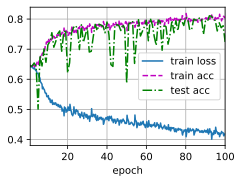

In [60]:
lr, num_epochs = 1e-1, 100
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())